<a href="https://colab.research.google.com/github/MariiaKalinina/Elasticity/blob/main/Rosatom.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import torch
from math import *
from scipy import integrate
from numpy import linalg as LA
import matplotlib.pyplot as plt
%matplotlib inline
from numba import njit
import numpy as np
from scipy.integrate import dblquad

import matplotlib.pylab as plt
import seaborn as sns
import pandas as pd
from pathlib import Path
import matplotlib.colors

import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
%matplotlib inline
csfont = {'fontname':'Times New Roman'}

In [17]:
path_to_ser = Path('/content/Rosatom.xlsx')
data = pd.read_excel(path_to_ser, skiprows=0)
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [18]:
data[:5]

,Sample ID,"Depth (TC), m","TC, Вт/(мК)","Глубина (ГК),м","ГК, мкР/час","Глубина (ГГК-п), м",ГГК-п имп/мин,Unnamed: 7,"Глубина (ПС), м",ПС,№ образца,Глубина,№ ящика,Интервал,"Top, m","Bot, m","L, m",Lcorr,Примечание,Литологическое описание
0,#,30.525,NaN,0.1,9.27,1.9,48640.0,NaN,12.44,663.50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,625,30.526,NaN,0.2,9.67,2.0,50190.0,NaN,12.54,520.10,636.0,37.84,13.0,"36,3-39,3",37.845,37.894,0.049,NaN,NaN,Долерит
2,625,30.527,NaN,0.3,10.12,2.1,50580.0,NaN,12.64,387.37,612.0,41.93,14.0,"39,3-42",41.935,42.012,0.077,NaN,2D + 3D,Спессартит
3,625,30.528,NaN,0.4,9.94,2.2,50580.0,NaN,12.74,361.20,594.0,44.45,15.0,"42-44,8",44.455,44.550,0.095,NaN,NaN,Долерит
4,625,30.529,NaN,0.5,9.98,2.3,51220.0,NaN,12.84,360.66,587.0,45.37,16.0,"44,8-47,8",45.375,45.491,0.116,распилен,NaN,Спессартит


In [30]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# Your imports
from mlxtend.plotting import plot_decision_regions

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, QuantileTransformer, FunctionTransformer, MinMaxScaler
from sklearn.random_projection import GaussianRandomProjection
from sklearn.decomposition import PCA

from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error as mse

from sklearn.model_selection import GridSearchCV, PredefinedSplit

import time
import math
from sklearn.metrics import roc_curve, average_precision_score

import warnings
warnings.filterwarnings('ignore')

<Axes: xlabel='TC, Вт/(мК)', ylabel='Probability'>

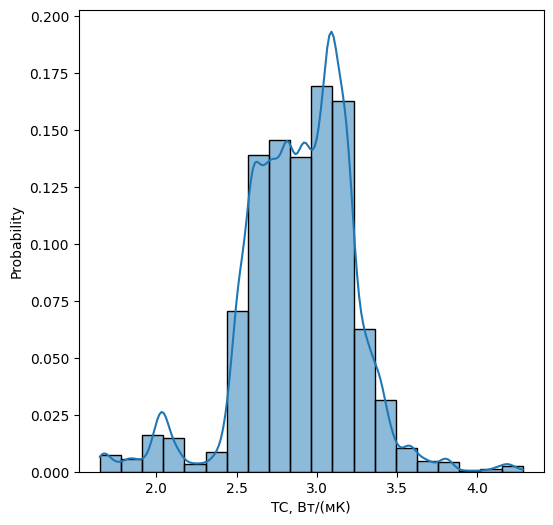

In [4]:
plt.figure(figsize=(6, 6))
sns.histplot(data=data, x='TC, Вт/(мК)', stat="probability", kde=True, bins=20)

In [7]:
data.columns

Index(['Sample ID', 'Depth (TC), m', 'TC, Вт/(мК)', 'Глубина (ГК),м',
       'ГК, мкР/час', 'Глубина (ГГК-п), м', 'ГГК-п имп/мин', 'Unnamed: 7',
       'Глубина (ПС), м', 'ПС', '№ образца', 'Глубина', '№ ящика', 'Интервал',
       'Top, m', 'Bot, m', 'L, m', 'Lcorr', 'Примечание',
       'Литологическое описание'],
      dtype='object')

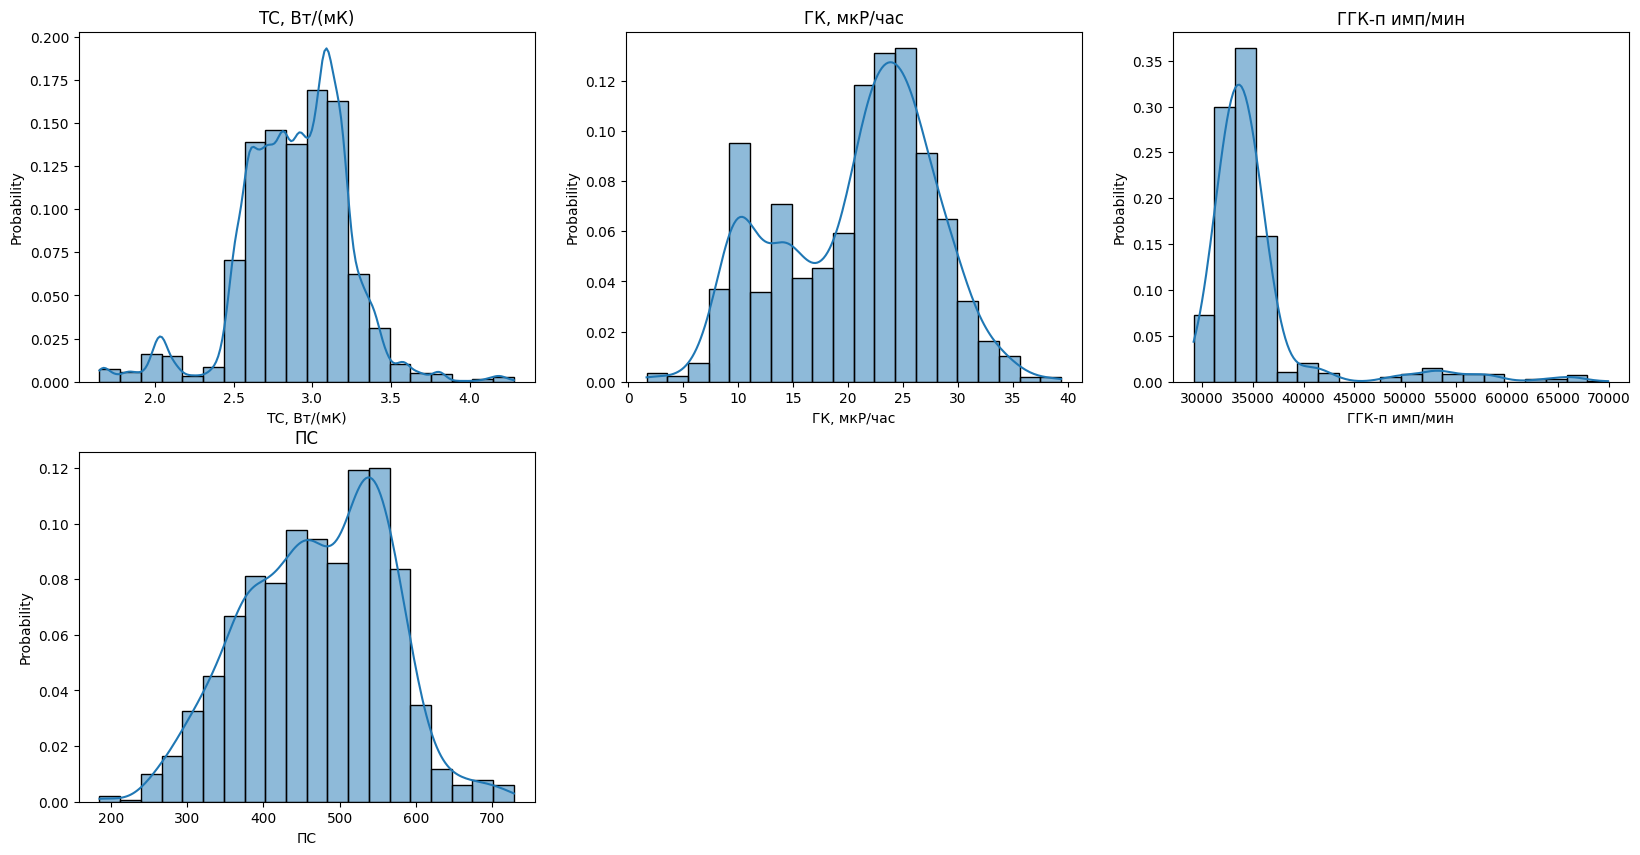

In [5]:
### BEGIN Solution (do not delete this comment)

fig = plt.figure(figsize=(20, 10))

parametrs_list = [
    "TC, Вт/(мК)",
    "ГК, мкР/час",
    "ГГК-п имп/мин",
    "ПС"
]

for index, tmp in enumerate(parametrs_list):
  x_parametr = tmp
  ax = plt.subplot(2, 3, index + 1)
  fig = sns.histplot(data=data, x=x_parametr, stat="probability", kde=True, bins=20)
  plt.title(f'{str(tmp)}')

### END Solution (do not delete this comment)

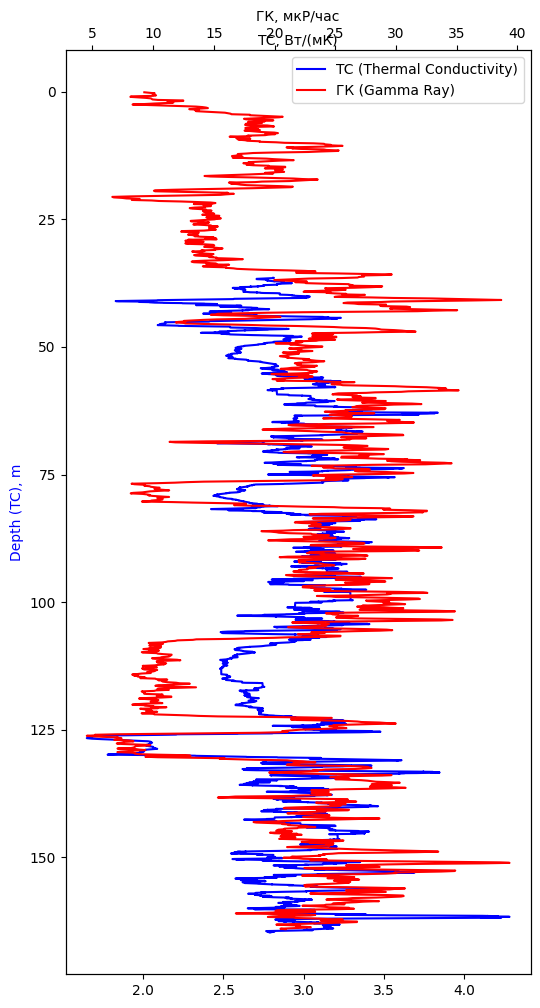

In [9]:
fig, ax1 = plt.subplots(figsize=(6, 12))

# Data for the first plot
x1, y1 = data["TC, Вт/(мК)"], data["Depth (TC), m"]
ax1.plot(x1, y1, 'b-', label='TC (Thermal Conductivity)')
ax1.set_ylabel('Depth (TC), m', color='b')
ax1.invert_yaxis()  # Invert the y-axis for the first plot
ax1.xaxis.tick_top()  # Move the x-axis to the top
ax1.xaxis.set_label_position('top')  # Label for the x-axis on top
ax1.set_xlabel('TC, Вт/(мК)')

# Create a second x-axis for the second plot
ax2 = ax1.twiny()  # This creates a new x-axis that shares the y-axis with ax1
x2, y2 = data["ГК, мкР/час"], data["Глубина (ГК),м"]
ax2.plot(x2, y2, 'r-', label='ГК (Gamma Ray)')
ax2.set_xlabel('ГК, мкР/час')

# Set y-axis label for the second plot (optional if you want separate y-axis labels)
ax2.set_ylabel('Глубина (ГК),м', color='r')

# Add legends to the plot
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='best')

plt.show()

In [10]:
data['TC, Вт/(мК)'].shape, data["Depth (TC), m"].shape, data["ГК, мкР/час"].shape, data["Глубина (ГК),м"].shape

((97768,), (97768,), (97768,), (97768,))

In [11]:
data.columns

Index(['Sample ID', 'Depth (TC), m', 'TC, Вт/(мК)', 'Глубина (ГК),м',
       'ГК, мкР/час', 'Глубина (ГГК-п), м', 'ГГК-п имп/мин', 'Unnamed: 7',
       'Глубина (ПС), м', 'ПС', '№ образца', 'Глубина', '№ ящика', 'Интервал',
       'Top, m', 'Bot, m', 'L, m', 'Lcorr', 'Примечание',
       'Литологическое описание'],
      dtype='object')

In [19]:
merged_data = pd.merge(
    data[['TC, Вт/(мК)', 'Depth (TC), m']],
    data[['ГК, мкР/час', 'Глубина (ГК),м']],
    left_on='Depth (TC), m',
    right_on='Глубина (ГК),м',
    how='inner'
)

In [20]:
merged_data

,"TC, Вт/(мК)","Depth (TC), m","ГК, мкР/час","Глубина (ГК),м"
0,2.815388,37.1,21.82,37.1
1,2.666176,38.2,28.83,38.2
2,2.598122,38.6,24.24,38.6
3,2.623626,38.7,24.42,38.7
4,2.627114,39.2,22.39,39.2
...,...,...,...,...
96672,NaN,NaN,NaN,NaN
96673,NaN,NaN,NaN,NaN
96674,NaN,NaN,NaN,NaN
96675,NaN,NaN,NaN,NaN


In [21]:
merged_data = merged_data.dropna(subset=['TC, Вт/(мК)'])
merged_data.drop(columns=['Глубина (ГК),м'], inplace=True)
merged_data

<ipython-input-21-e6d608ed09d9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_data.drop(columns=['Глубина (ГК),м'], inplace=True)


,"TC, Вт/(мК)","Depth (TC), m","ГК, мкР/час"
0,2.815388,37.1,21.82
1,2.666176,38.2,28.83
2,2.598122,38.6,24.24
3,2.623626,38.7,24.42
4,2.627114,39.2,22.39
...,...,...,...
545,3.129074,163.3,21.05
546,3.136196,163.7,22.99
547,3.134156,163.8,22.50
548,3.153052,163.9,21.41


In [22]:
merged_data = pd.merge(
    merged_data,
    data[['ГГК-п имп/мин', 'Глубина (ГГК-п), м']],
    left_on='Depth (TC), m',
    right_on='Глубина (ГГК-п), м',
    how='inner'
)

merged_data.drop(columns=['Глубина (ГГК-п), м'], inplace=True)


# Rename columns for clarity if necessary
merged_data.rename(columns={
    'TC, Вт/(мК)': 'TC Value',
    'ГК, мкР/час': 'ГК Value',
    'ГГК-п имп/мин': 'ГГК-п Value',
    'Depth (TC), m': 'Common Depth'
}, inplace=True)

merged_data



,TC Value,Common Depth,ГК Value,ГГК-п Value
0,2.815388,37.1,21.82,35620.00
1,2.666176,38.2,28.83,36133.33
2,2.598122,38.6,24.24,35565.00
3,2.623626,38.7,24.42,35685.00
4,2.627114,39.2,22.39,36366.67
...,...,...,...,...
545,3.129074,163.3,21.05,32780.00
546,3.136196,163.7,22.99,32540.00
547,3.134156,163.8,22.50,33155.00
548,3.153052,163.9,21.41,33695.00


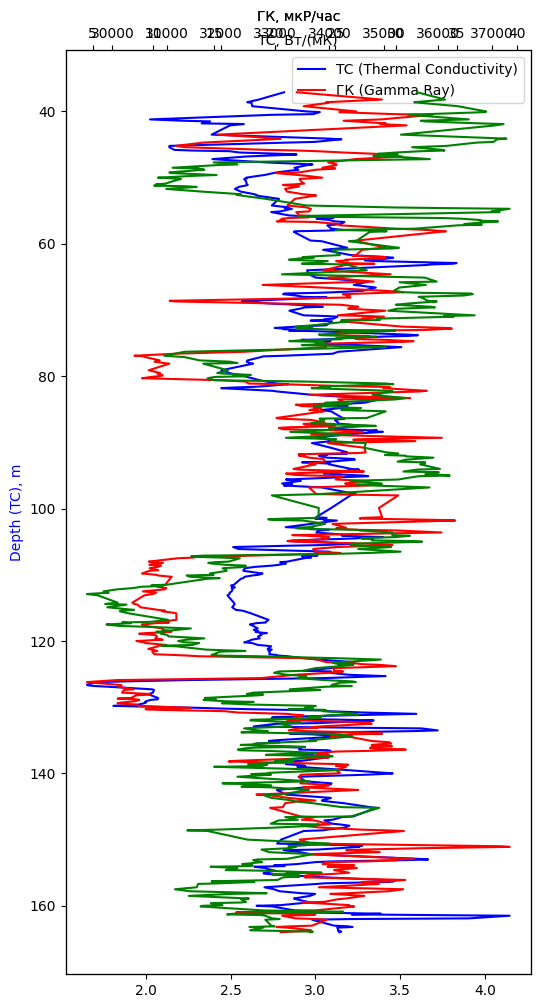

In [24]:
fig, ax1 = plt.subplots(figsize=(6, 12))

data = merged_data

# Data for the first plot
x1, y1 = data["TC Value"], data["Common Depth"]
ax1.plot(x1, y1, 'b-', label='TC (Thermal Conductivity)')
ax1.set_ylabel('Depth (TC), m', color='b')
ax1.invert_yaxis()  # Invert the y-axis for the first plot
ax1.xaxis.tick_top()  # Move the x-axis to the top
ax1.xaxis.set_label_position('top')  # Label for the x-axis on top
ax1.set_xlabel('TC, Вт/(мК)')

# Create a second x-axis for the second plot
ax2 = ax1.twiny()  # This creates a new x-axis that shares the y-axis with ax1
x2, y2 = data["ГК Value"], data["Common Depth"]
ax2.plot(x2, y2, 'r-', label='ГК (Gamma Ray)')
ax2.set_xlabel('ГК, мкР/час')

# Set y-axis label for the second plot (optional if you want separate y-axis labels)
ax2.set_ylabel('Глубина (ГК),м', color='r')

ax3 = ax1.twiny()  # This creates a new x-axis that shares the y-axis with ax1
x3, y3 = data["ГГК-п Value"], data["Common Depth"]
ax3.plot(x3, y3, 'g-', label='ГК (Gamma Ray)')
ax3.set_xlabel('ГК, мкР/час')

# Add legends to the plot
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='best')

plt.show()

In [28]:
merged_data.columns

Index(['TC Value', 'Common Depth', 'ГК Value', 'ГГК-п Value'], dtype='object')

In [38]:
X = merged_data.drop('TC Value', axis=1)
y = merged_data["TC Value"]
n = len(X)

<Axes: >

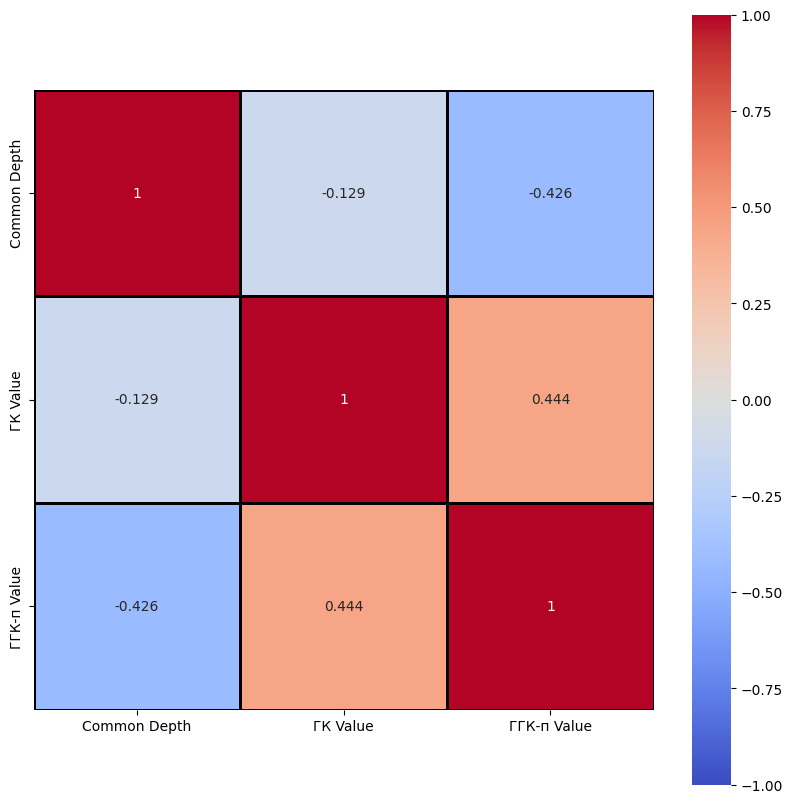

In [39]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(X.corr(),fmt = '.3g',square=True, annot = True, vmin=-1, vmax=1, center= 0, cmap= 'coolwarm', linewidths=1, linecolor='black')

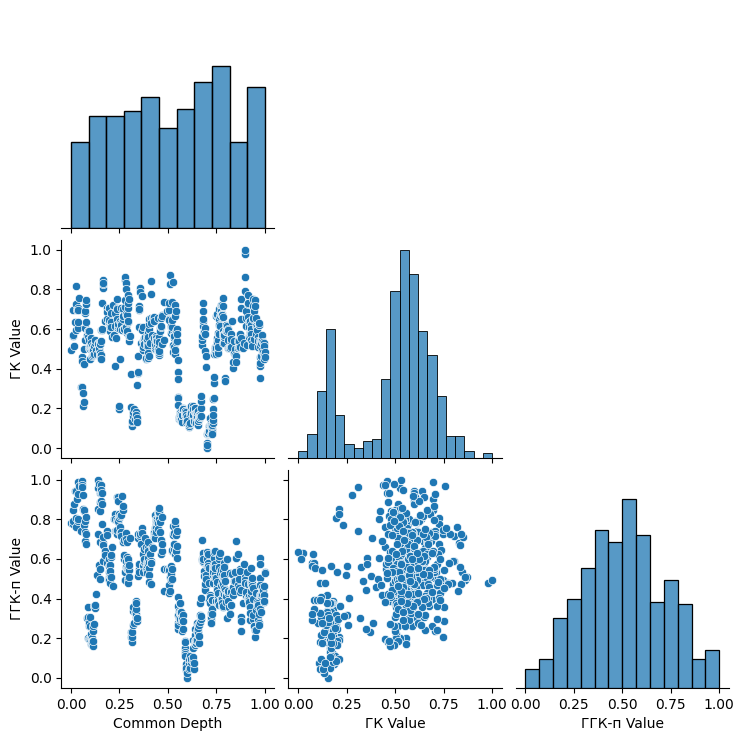

In [62]:
sns.pairplot(data=X, corner=True)

In [41]:
# Normalization of data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
columns_name = X.select_dtypes(include='float64')
X[list(columns_name)] = scaler.fit_transform(X[list(columns_name)])

In [42]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=int(n*0.15), random_state=0xC0FFEE)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=int(n*0.15), random_state=0xC0FFEE)

# merged_data.sample(3).sort_index()

,TC Value,Common Depth,ГК Value,ГГК-п Value
211,2.979810,90.1,24.39,34673.33
465,3.038300,144.1,23.36,33344.00
547,3.134156,163.8,22.50,33155.00


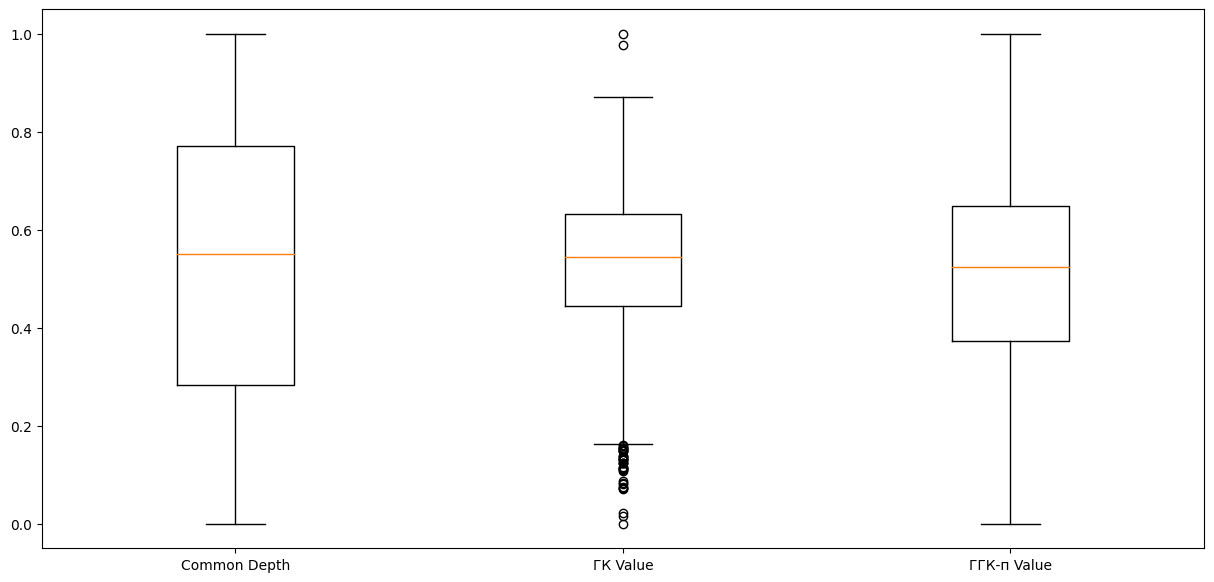

RandomForestRegressor:
Train mse: 0.01
Train R^2: 0.91
Validation: 0.04
Validation R^2: 0.47
Test: 0.03
Test  R^2: 0.71
{'max_features': 2, 'min_samples_split': 6, 'n_estimators': 10} 

ExtraTreesRegressor:
Train mse: 0.01
Train R^2: 0.93
Validation: 0.04
Validation R^2: 0.51
Test: 0.03
Test  R^2: 0.75
{'max_features': 3, 'min_samples_split': 6, 'n_estimators': 10} 

XGBRegressor:
Train mse: 0.05
Train R^2: 0.65
Validation: 0.04
Validation R^2: 0.38
Test: 0.03
Test  R^2: 0.64
{'learning_rate': 0.5025, 'max_depth': 1, 'n_estimators': 27} 



In [68]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import xgboost as xgb


plt.figure(figsize=(15, 7))

# Assuming X_train is defined and is a DataFrame
data = [X_train[i] for i in X_train.columns]

plt.boxplot(data, labels=X_train.columns)
plt.show()

models_list = [
    RandomForestRegressor(random_state=0xC0FFEE),
    ExtraTreesRegressor(random_state=0xC0FFEE),
    xgb.XGBRegressor(random_state=0xC0FFEE)

]

# Ensure that the range for max_features is valid
min_features = min(1, X_train.shape[1])
max_features = max(1, X_train.shape[1])

p_g1 = {
    'max_features': np.arange(min_features, max_features + 1),
    'n_estimators': np.linspace(2, 10, 4, dtype=int),
    'min_samples_split': np.arange(2, 10, 2),
}

p_g2 = {
    'max_features': np.arange(min_features, max_features + 1),
    'n_estimators': np.linspace(2, 10, 4, dtype=int),
    'min_samples_split': np.arange(2, 10, 2),
}

p_g3 = {
    "max_depth": np.arange(min_features, max_features + 1),
    'n_estimators': np.linspace(2, 40, 4, dtype=int),
    "learning_rate": np.linspace(0.005, 1 , 5),
}

params_list = [p_g1, p_g2, p_g3]

for reg, grid in zip(models_list, params_list):
  # search for the optimal hyperparameters
    gs = GridSearchCV(reg, param_grid=grid, n_jobs=-1)
    gs.fit(X_val, y_val)
    best_reg = reg.__class__(**gs.best_params_)
    print(f'{type(reg).__name__}:')


  # use these values for our hyperparameters in the final calculation
    best_reg.fit(X_train, y_train)
    y_pred = best_reg.predict(X_train)
    print('Train mse:', mean_squared_error(y_pred, y_train).round(2))
    print('Train R^2:', r2_score(y_train, y_pred).round(2))

    y_pred = best_reg.predict(X_val)
    print('Validation:', mean_squared_error(y_pred, y_val).round(2))
    print('Validation R^2:', r2_score(y_pred, y_val).round(2))

    y_pred = best_reg.predict(X_test)
    print('Test:', mean_squared_error(y_pred, y_test).round(2))
    print('Test  R^2:', r2_score(y_pred, y_test).round(2))
    print(gs.best_params_, '\n')

Train R^2: 0.67


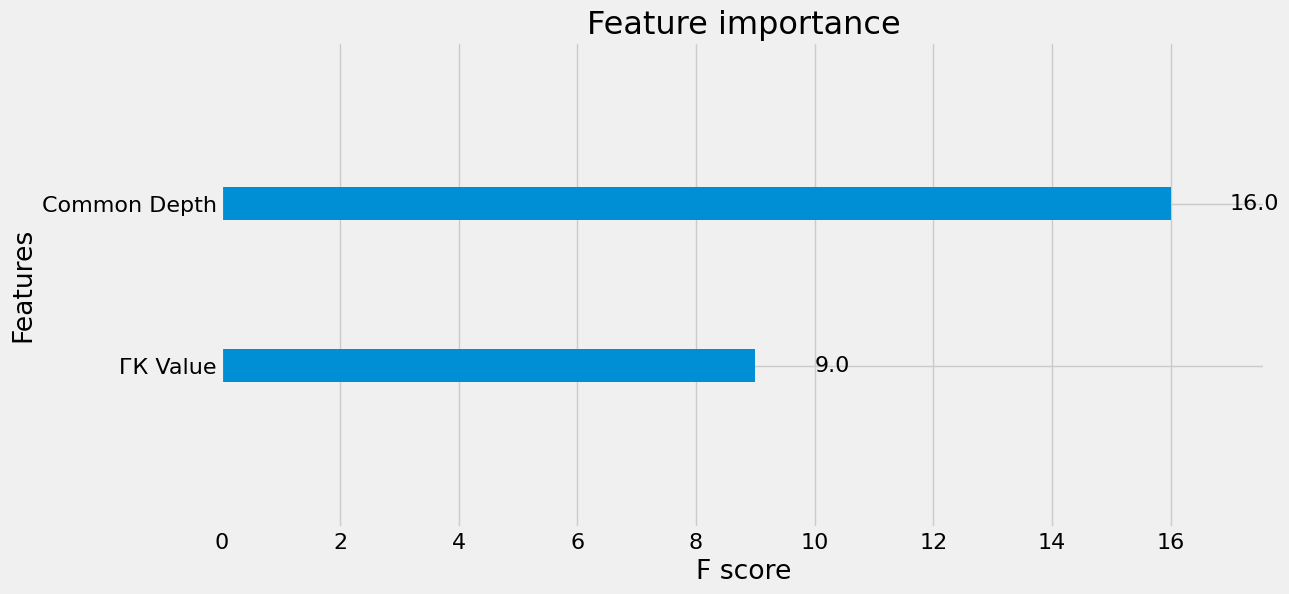

(1.5, 4.0)

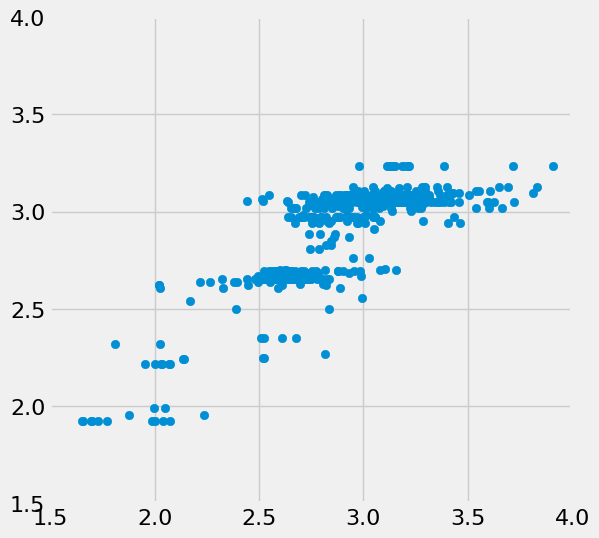

In [79]:
best_xgb_regressor=xgb.XGBRegressor(
                          learning_rate = 0.5025,
                          n_estimators  = 27,
                          max_depth     = 1,
                          eval_metric='rmse')

X_train,X_test,y_train,y_test = train_test_split(X, y, test_size = 0.12)
best_xgb_regressor.fit(X_train, y_train)
predictions = best_xgb_regressor.predict(X_test)
print('Train R^2:', r2_score(y_test, predictions).round(2))


# the feature importance for xgb!
from xgboost import plot_importance
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')
plt.rcParams.update({'font.size': 16})

fig, ax = plt.subplots(figsize=(12,6))
plot_importance(best_xgb_regressor, max_num_features=2, ax=ax)
plt.show();


# prediction for the whole dataset
y_pred = best_xgb_regressor.predict(X)

fig, ax = plt.subplots(figsize=(6,6))
plt.scatter(y, y_pred)
plt.xlim(1.5, 4)
plt.ylim(1.5, 4)

In [84]:

# Assuming X and y are defined and are your full dataset and targets
# Assuming X_train, X_val, y_train, y_val are subsets used for the grid search

# Define the parameter grid based on previous setup
param_grid = {
    'max_features': np.arange(min(1, X_train.shape[1]), max(1, X_train.shape[1]) + 1),
    'n_estimators': np.linspace(2, 10, 4, dtype=int),
    'min_samples_split': np.arange(2, 10, 2),
}

# Initialize the ExtraTreesRegressor with a fixed random state
extra_trees = ExtraTreesRegressor(random_state=0xC0FFEE)

# Setup GridSearchCV
gs = GridSearchCV(extra_trees, param_grid=param_grid, n_jobs=-1)
gs.fit(X_val, y_val)  # Fit on validation set, or use another appropriate subset

# Extract the best parameters and fit on the entire dataset
best_params = gs.best_params_
best_extra_trees = ExtraTreesRegressor(**best_params, random_state=0xC0FFEE)
best_extra_trees.fit(X, y)  # Fit on the entire dataset
print(best_params)

# Predict the values of y
y_pred = best_extra_trees.predict(X)

{'max_features': 3, 'min_samples_split': 6, 'n_estimators': 10}


(1.5, 4.0)

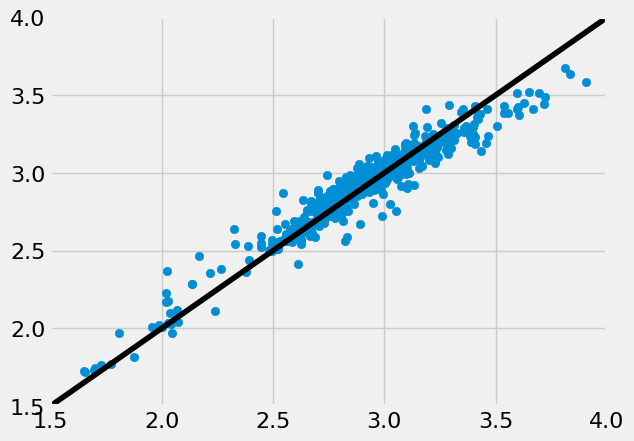

In [86]:
plt.scatter(y, y_pred)
plt.plot([1,5], [1,5], color='black')
plt.xlim(1.5, 4)
plt.ylim(1.5, 4)

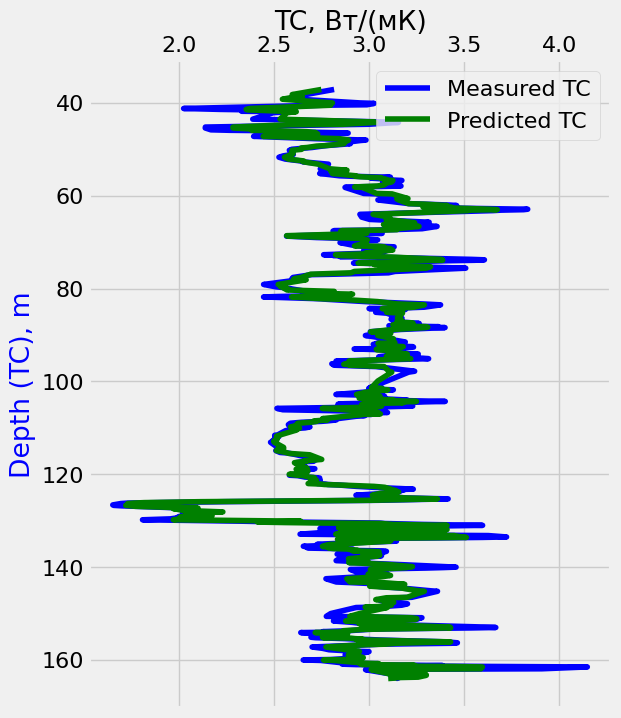

In [87]:
fig, ax1 = plt.subplots(figsize=(6, 8))

data = merged_data

# Data for the first plot
x1, y1 = data["TC Value"], data["Common Depth"]
ax1.plot(x1, y1, 'b-', label='Measured TC')
x1, y1 = y_pred, data["Common Depth"]
ax1.plot(x1, y1, 'g-', label='Predicted TC')
ax1.set_ylabel('Depth (TC), m', color='b')

ax1.invert_yaxis()  # Invert the y-axis for the first plot
ax1.xaxis.tick_top()  # Move the x-axis to the top
ax1.xaxis.set_label_position('top')  # Label for the x-axis on top
ax1.set_xlabel('TC, Вт/(мК)')
ax1.legend()

plt.show()

In [57]:
path_to_ser = Path('/content/Rosatom.xlsx')
data = pd.read_excel(path_to_ser, skiprows=0)
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [ ]:
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import GridSearchCV
import numpy as np

# Assuming X and y are defined and are your full dataset and targets
# Assuming X_train, X_val, y_train, y_val are subsets used for the grid search

# Define the parameter grid based on previous setup
param_grid = {
    'max_features': np.arange(min(1, X_train.shape[1]), max(1, X_train.shape[1]) + 1),
    'n_estimators': np.linspace(2, 10, 4, dtype=int),
    'min_samples_split': np.arange(2, 10, 2),
}

# Initialize the ExtraTreesRegressor with a fixed random state
extra_trees = ExtraTreesRegressor(random_state=0xC0FFEE)

# Setup GridSearchCV
gs = GridSearchCV(extra_trees, param_grid=param_grid, n_jobs=-1)
gs.fit(X_val, y_val)  # Fit on validation set, or use another appropriate subset

# Extract the best parameters and fit on the entire dataset
best_params = gs.best_params_
best_extra_trees = ExtraTreesRegressor(**best_params, random_state=0xC0FFEE)
best_extra_trees.fit(X, y)  # Fit on the entire dataset
print(best_params)

# Predict the values of y
y_pred = best_extra_trees.predict(X)